# Neural Net for Semantic Image Segmentation
#### Kaggle Competition (https://www.kaggle.com/c/cvpr-2018-autonomous-driving)
#### Stanford course CS231n
#### Aristos Athens (aristos@stanford.edu)
#### Alice Li (ali2@stanford.edu)
#### Amelia Bian (qb1@stanford.edu)

In [1]:
import os
import tensorflow as tf
import numpy as np
import glob
import math
import random
import timeit
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image

import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet

%matplotlib inline

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## HyperParameters

In [2]:
class HyperParameters:
    """
    Object to hold all hyperparameters. Makes passing parameters between functions easier.
    Many of these might not be strictly necessary.
    
    """
    def __init__(self):
        self.data_type = tf.float32
#         self.device = tf.device('cpu')  # options: 'cuda', 'cpu', etc
        self.root = '../data/cvpr-2018-autonomous-driving/train_color'
        self.device = '/cpu:0'
        self.preload = True  #options: True, False
        self.optimizer = "Adam" #options: Momentum, Adam, Adagrad
        self.learning_rate = 1e-4
        self.momentum = 0.9
        self.use_Nesterov = True
        self.init_scale = 2.0
        self.shuffle_data = True
        self.batch_size = 10
        self.num_epochs = 10
        self.image_model = tf.global_variables_initializer()
        
              
hp = HyperParameters()

## Here we create a customized data loader for the CVPR dataset

In [3]:
class CVPR(object):
    """
    A customized data loader for CVPR.
    """
    def __init__(self, root, preload=False, transform=None, batch_size = 64, shuffle = True):
        """ Intialize the CVPR dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.transform = transform
        
        # read filenames
        filenames = glob.glob(osp.join(root, '*.jpg'))
        for fn in filenames:
            lbl = fn[:-4] + '_instanceIds.png'
            lbl = lbl.replace('color', 'label')
            self.filenames.append((fn, lbl)) # (filename, label) pair
            if len(self.filenames) >= 100: 
                break
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
#         tf.reset_default_graph() 
        for image_fn, label in self.filenames:
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(np.asarray(image))
            image.close()
            # load labels
            image = Image.open(label)
            # avoid too many opened files bug
            self.labels.append(np.asarray(image))
            image.close()
    
        assert len(self.images) == len(self.labels), 'Got different numbers of data and labels'
        # assert self.images[0].shape == self.labels[0].shape, 'Got data and labels with different shapes'

        
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            label = Image.open(label)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
            label = self.transform(label)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
    
    
    def __iter__(self):
        N, B = len(self.images), self.batch_size
        idxs = np.arange(N)
#         if self.shuffle:
#             np.random.shuffle(idxs)
        return iter((self.images[i:i+B], self.labels[i:i+B]) for i in range(0, N, B))

## Create a data set object

In [4]:
data_set = CVPR(hp.root, hp.preload, transform = tf.convert_to_tensor, shuffle = hp.shuffle_data)
print(len(data_set))


100


## show_image() function

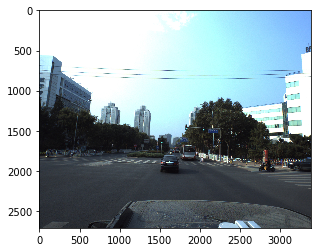

In [5]:
# Define function to show images
# Takes an image as a tensor

def show_image(hp, image_tensor):
    with tf.Session() as session:
        session.run(hp.image_model)
        result = session.run(image_tensor)

    plt.imshow(result)
    plt.show()

# Print a random example image
index = random.randrange(0, len(data_set))
image, label = data_set.__getitem__(index)
show_image(hp, image)

In [6]:
print(index)
print(len(data_set.labels))
print(len(data_set.images))
input_shape = data_set.images[0].shape
print(input_shape)
print(data_set.labels[0].shape)

38
100
100
(2710, 3384, 3)
(2710, 3384)


## Define Net

In [ ]:
def create_model(inputs, is_training):
    
    initializer = tf.variance_scaling_initializer(scale=hp.init_scale)
    
    # Transfer learning example here:
    # https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
#     model = inception_v3.InceptionV3(weights='imagenet')
#     model = vgg16.VGG16(weights='imagenet')
#     model = resnet50.ResNet50(weights='imagenet')
    
    # Freeze weights in model - stops auto backprop on these layers
#     for layer in model.layers:
#         layer.trainable = False
    
    # Not 100% sure what this line does
#     model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Add our own layers to the layers list within the model
    layers = [
        tf.keras.layers.Conv2D(3, (3, 3), activation="relu", kernel_initializer = initializer, input_shape=input_shape, padding = "SAME"),
        tf.keras.layers.Conv2D(1, (5, 5), activation="relu", kernel_initializer = initializer, padding = "SAME"),
    ]
    model = tf.keras.Sequential(layers)

    return model(inputs)

def create_optimizer(hp):
    
    optimizer = None
    if hp.optimizer == "Momentum":    
        optimizer = tf.train.MomentumOptimizer(learning_rate=hp.learning_rate, momentum=hp.momentum, use_nesterov=hp.use_Nesterov)
    if hp.optimizer == "Adam":    
        optimizer = tf.train.AdamOptimizer(learning_rate=hp.learning_rate)
    if hp.optimizer == "AdaGrad":
        optimizer = tf.train.AdagradOptimizer(learning_rate=hp.learning_rate)
    
    return optimizer

In [ ]:
def train_net(hp, data_set, model_init_fn, optimizer_init_fn, num_epochs=10):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during training
    """
#     tf.reset_default_graph()    
    with tf.device(hp.device):
        # Construct the computational graph we will use to train the model. We
        # use the model_init_fn to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(hp.data_type, [None, 2710, 3384, 3])
        y = tf.placeholder(hp.data_type, [None, 2710, 3384])
        
        # We need a place holder to explicitly specify if the model is in the training
        # phase or not. This is because a number of layers behaves differently in
        # training and in testing, e.g., dropout and batch normalization.
        # We pass this variable to the computation graph through feed_dict as shown below.
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        # Use the model function to build the forward pass.
        output = tf.squeeze(model_init_fn(x, is_training))
        loss = tf.reduce_mean(tf.square(y - output))

        # Use the optimizer_fn to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.
        
        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.
        
#         optimizer = tf.train.AdamOptimizer().minimize(cost)
        
        optimizer = create_optimizer(hp).minimize(loss)
#         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#         with tf.control_dependencies(update_ops):
#             train_op = optimizer.minimize(loss)

    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the
    # model to update.
    print("got to loop!")

    data_iterator = data_set.__iter__()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(num_epochs):
            print('Starting epoch %d' % epoch)
            train_images, train_labels = next(data_iterator)
            feed_dict = {x: train_images, y: train_labels, is_training: 1}
            loss_value, _ = sess.run([optimizer, loss], feed_dict=feed_dict)
            print('Epoch %d Loss = %.4f' % (epoch, loss_value))
            print()

                
train_net(hp, data_set, create_model, create_optimizer, num_epochs=hp.num_epochs)

got to loop!
Starting epoch 0
